# Air bnb Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



Reading dataset into a pandas dataframe

In [3]:
df = pd.read_csv('Data\AB_NYC_2019.csv')

In [4]:
df.shape

(48895, 16)

In [5]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Step 1: Analysis/Preprocessing

Missing values

In [6]:
features_with_na = [feature  for feature in df.columns if df[feature].isnull().sum() >= 1]

for feature in features_with_na:
    print(feature, ':', np.round(df[feature].isnull().mean(), 4), "% missing values")

name : 0.0003 % missing values
host_name : 0.0004 % missing values
last_review : 0.2056 % missing values
reviews_per_month : 0.2056 % missing values


Now I will check if the nightly price has strong dependencies on the missing values

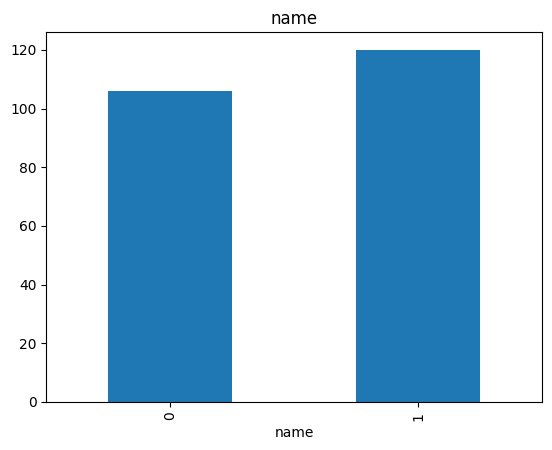

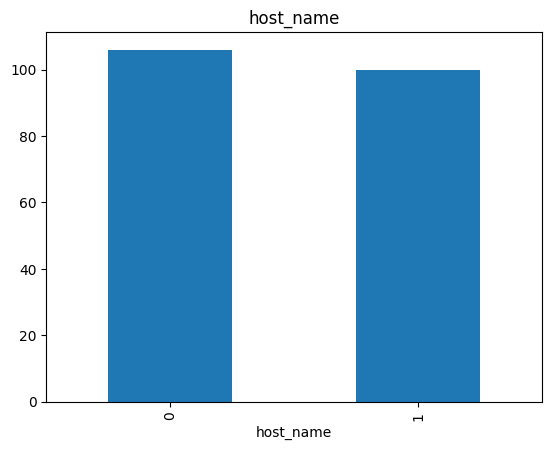

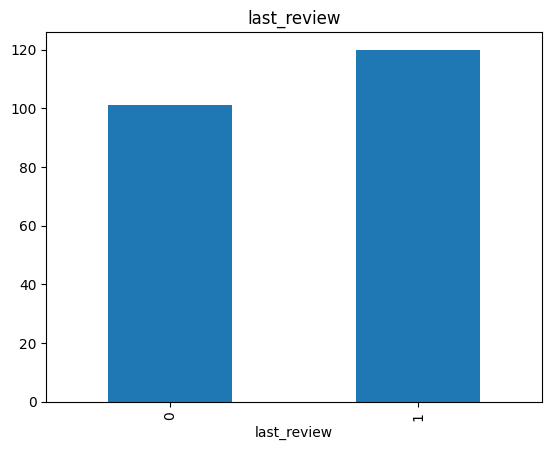

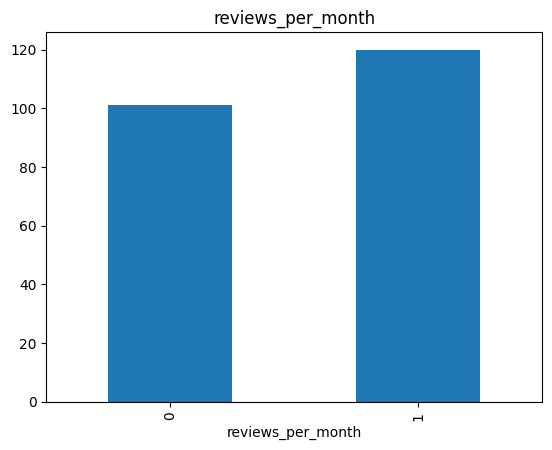

In [7]:
for feature in features_with_na:
    data = df.copy()

    data[feature] = np.where(data[feature].isnull(), 1, 0)

    data.groupby(feature)['price'].median().plot.bar()

    plt.title(feature)
    plt.show()

The name and host name missing values are so minute (around 0.0002) % so I will not be focusing too much on those missing values, and will be dropping the entries with missing values

However the missing values of the reviews are more significant (around 0.2056) and also show that that the price of the air bnb has some dependcies on it -  you can see in the bar chart that the median price of the entires that have missing values (1) is around 120, while the median price of the entries that do not include missing values (0) is around 100

This could be for a few reasons, if it is a newer building then it might be a higher price than an older one, and might not have been available for long enough for people to give them reviews

Also if they are more luxury or expensive, then it could be rented infrequently and therefore lack review data

This is all to show that I will not be ignoring the missing values in these features, but I will make sure to model them instead 

Numerical Features

In [8]:
numerical_featurs = [feature for feature in df.columns if df[feature].dtypes != 'O']

print(f'Number of numerical features = {len(numerical_featurs)}')

df.head()

Number of numerical features = 10


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [9]:
print(numerical_featurs)


['id', 'host_id', 'latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


Temporal features

In [10]:
temporal_features = [feature for feature in df.columns if df[feature].dtype == 'datetime64[ns]']

print(temporal_features)

[]


In [11]:
string_features = [feature for feature in df.columns if df[feature].dtype == 'object']

print(string_features)

['name', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'last_review']


You can see that the dataframe is not treating the last review as a date_time object, so I will have to change that

In [12]:
df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')

In [13]:
temporal_features = [feature for feature in df.columns if df[feature].dtype == 'datetime64[ns]']

print(temporal_features)

['last_review']


Now I will plot the last review with the price to see if there are any patterns that stand out

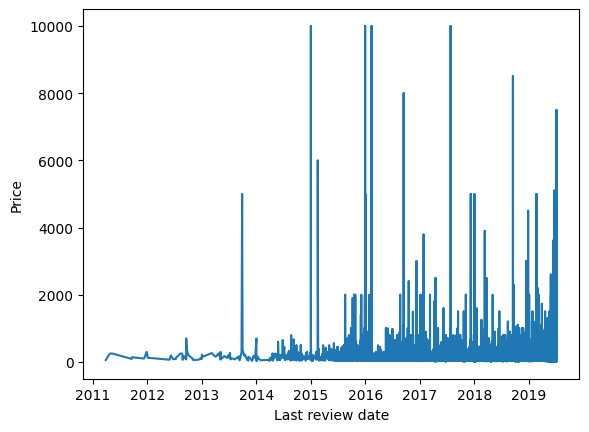

In [14]:
df_sorted = df.sort_values('last_review')

plt.plot(df_sorted['last_review'], df_sorted['price'])

plt.xlabel('Last review date')
plt.ylabel('Price')

plt.show()

too noisy so I will resample

C:\Users\logan\AppData\Local\Temp\ipykernel_20128\1980788542.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.set_index('last_review')['price'].resample('M').median().plot()


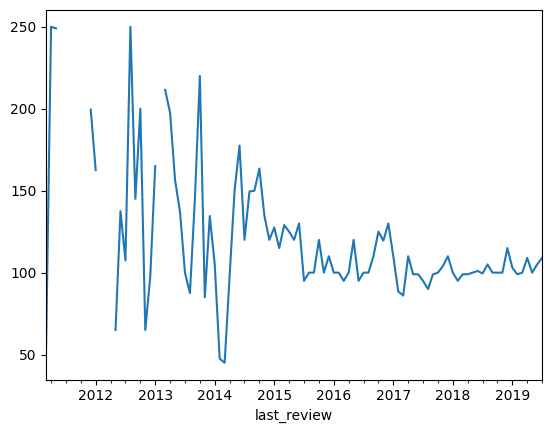

In [15]:
df.set_index('last_review')['price'].resample('M').median().plot()

plt.show()

no clear relationship, other than around 2015 the market gets a bit more stable, 

Discrete and continuous features

In [18]:
discrete_features = [feature for feature in numerical_featurs if len(df[feature].unique()) <= 25 and feature not in ['id']+['host_id']]

discrete_features

[]

no discrete features in dataset, all numerical features are continuous 

In [19]:
continuous_features = [feature for feature in numerical_featurs if feature not in ['id'] + ['host_id']]

continuous_features

['latitude',
 'longitude',
 'price',
 'minimum_nights',
 'number_of_reviews',
 'reviews_per_month',
 'calculated_host_listings_count',
 'availability_365']

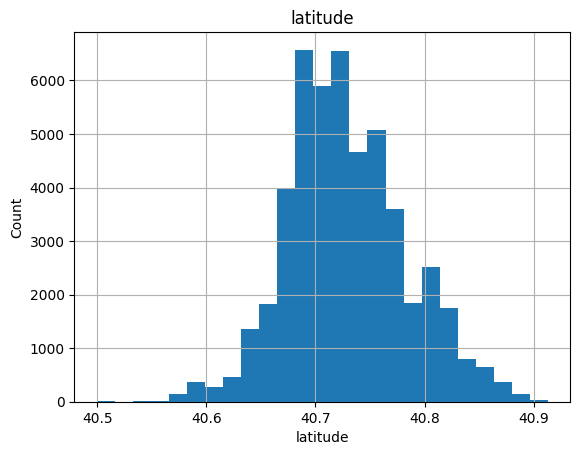

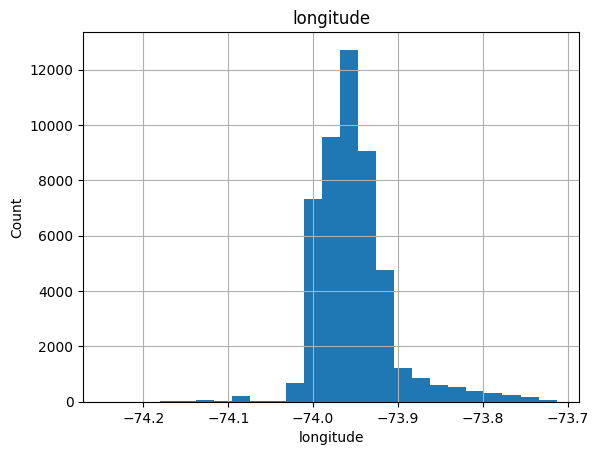

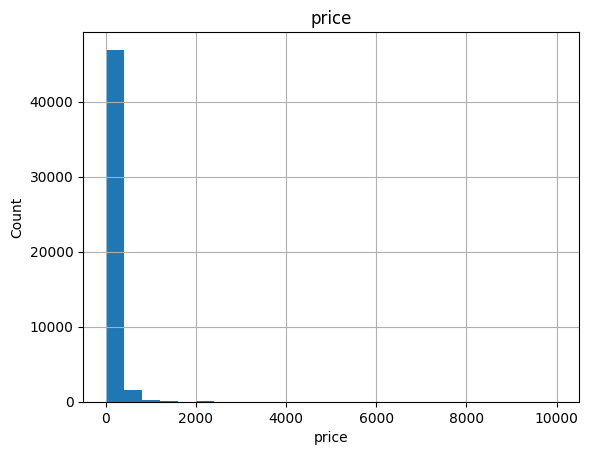

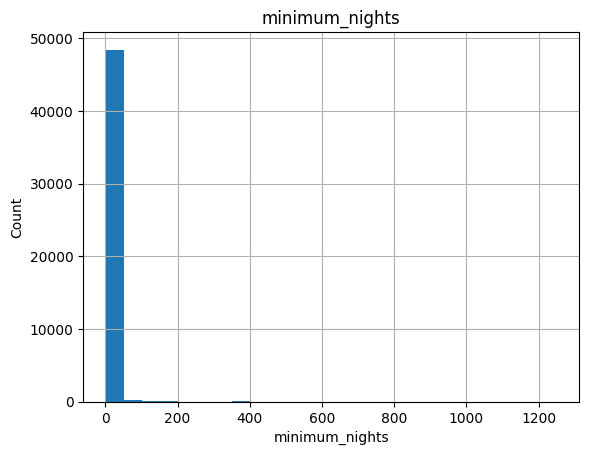

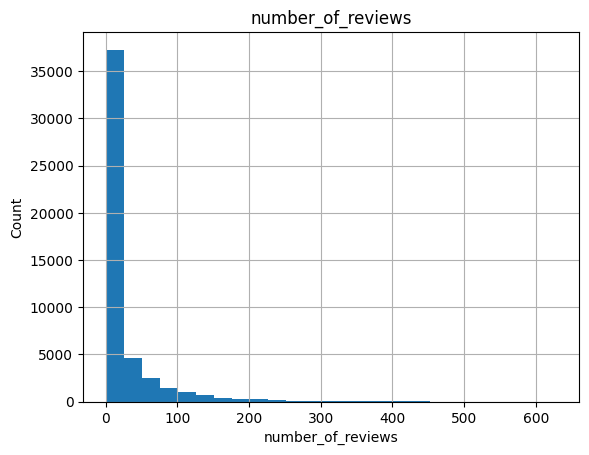

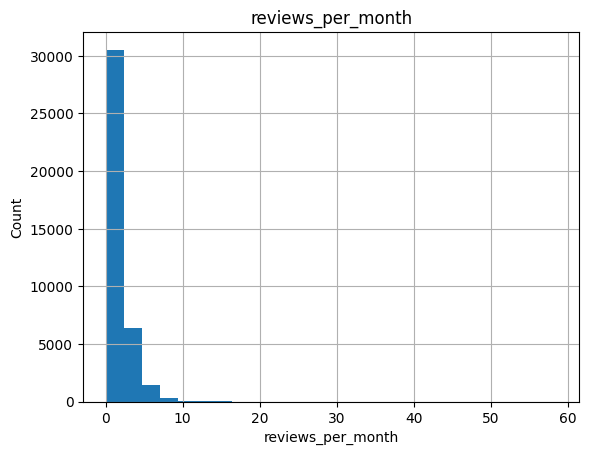

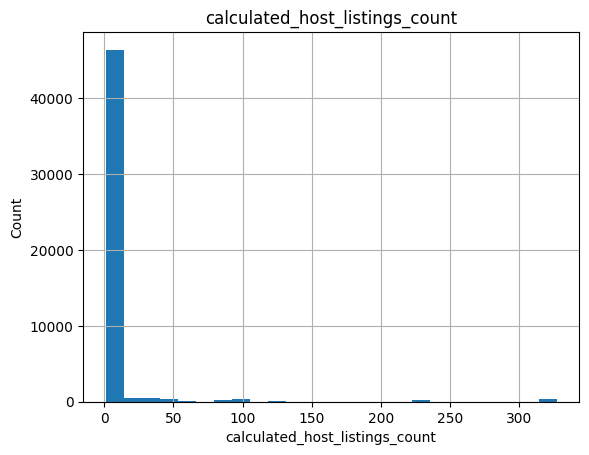

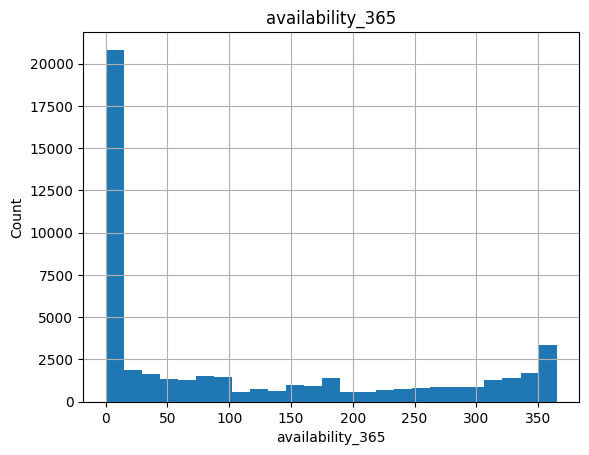

In [20]:
for feature in continuous_features:
    data = df.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.title(feature)
    plt.show()

latitude and longitude both follow a sort of gaussain distribution and wont need much normalization if we choose in feature selection.

However the other continuous features are very left skewed and will some sort of normalizaition or standardization if chosen